# Recommendation with LightGCN and LastFM Data

This tutorial demonstrates how to build a recommender system with the LastFM data. It uses the data loaders in [pyTigerGraph](https://docs.tigergraph.com/pytigergraph/current/intro/) to pull data from a TigerGraph database and trains a [LightGCN](https://arxiv.org/abs/2002.02126) model from the [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) package for recommendation.

The data used here are users' listening information from the last.fm music website, which comprises a heterogeneous graph between users and items (e.g. songs).  See below for the schema of this graph. There are 1,892 user vertices, 17,632 item vertices, and 92,834 interaction edges. The dataset is from [PyG datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.LastFM).

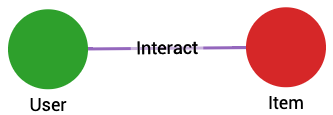

## Database Preparation

The `TigerGraphConnection` class represents a connection to the TigerGraph database. Under the hood, it stores the necessary information to communicate with the database. It is able to perform quite a few database tasks. Please see its [documentation](https://docs.tigergraph.com/pytigergraph/current/intro/) for details.

To connect your database, modify the `config.json` file accompanying this notebook. Set the value of `getToken` based on whether token auth is enabled for your database. Token auth is always enabled for tgcloud databases.

In [2]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('../../config.json', "r") as config_file:
    config = json.load(config_file)
    
conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"]
)

/Users/feng.shi/mlworkbench/lib/python3.9/site-packages/pyTigerGraph/pyTigerGraphBase.py:127: DeprecationWarning: The `debug` parameter is deprecated; configure standard logging in your app.
  warnings.warn(


Download LastFM dataset and ingest it to the database.

In [3]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("LastFM")

conn.ingestDataset(dataset, getToken=config["getToken"])

Downloading:   0%|          | 0/316950 [00:00<?, ?it/s]

---- Checking database ----
---- Creating graph ----
The graph LastFM is created.
---- Creating schema ----
Using graph 'LastFM'
Successfully created schema change jobs: [lastfm_schema].
Kick off schema change job lastfm_schema
Doing schema change on graph 'LastFM' (current version: 0)
Trying to add local vertex 'User' to the graph 'LastFM'.
Trying to add local vertex 'Item' to the graph 'LastFM'.
Trying to add local edge 'Interact' to the graph 'LastFM'.

Graph LastFM updated to new version 1
The job lastfm_schema completes in 1.384 seconds!
---- Creating loading job ----
Using graph 'LastFM'
Successfully created loading jobs: [Load_LastFM].
---- Ingesting data ----
[[{'sourceFileName': 'Online_POST', 'statistics': {'validLine': 92834, 'rejectLine': 0, 'failedConditionLine': 0, 'notEnoughToken': 0, 'invalidJson': 0, 'oversizeToken': 0, 'vertex': [{'typeName': 'User', 'validObject': 92834, 'noIdFound': 0, 'invalidAttribute': 0, 'invalidVertexType': 0, 'invalidPrimaryId': 0, 'invalidSec

Visualize schema

In [4]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Load data

Use graph loader to pull the whole graph from db. In this case, we are loading both the user ID and item ID as part of the vertex feature, and we are going to apply the training and testing filter for this data export. Notice that the output format for the data is PyG as we are leveraging the PyG library for the actual GNN model development.


In [6]:
graph_loader = conn.gds.graphLoader(
    num_batches=1,
    v_extra_feats={
        "User": ['id'],
        "Item": ["id"]},
    e_extra_feats={
        "Interact": ["is_train","is_test"]},
    output_format = "PyG")

Installing and optimizing queries. It might take a minute if this is the first time you use this loader.
Query installation finished.


In [7]:
data = graph_loader.data

Print a summary of the data to see what the graph looks like. It will show all the vertex and edge types in this graph and exported features. 

In [8]:
data

HeteroData(
  User={ id=[1892] },
  Item={ id=[17632] },
  (User, Interact, Item)={
    edge_index=[2, 185668],
    is_train=[185668],
    is_test=[185668]
  }
)

In [9]:
num_users = data["User"].id.shape[0]
num_items = data["Item"].id.shape[0]
num_nodes = num_users + num_items

print("Number of users: {}".format(num_users))
print("Number of items: {}".format(num_items))
print("Number of nodes: {}".format(num_nodes))

Number of users: 1892
Number of items: 17632
Number of nodes: 19524


Now that we have taken care of all the data needed to train the model, let's start the model development leveraging the pyG library. 

In [12]:
import torch
import scipy.sparse as ssp
import numpy as np
from torch_geometric.utils import coalesce

# Get user-item bi-adjacency matrix for testing
test_user_item = coalesce(data["Interact"]["edge_index"][:, data["Interact"].is_test])
# Convert the bi-adjacency matrix to the adjacency matrix of a unipartite graph. 
# Items are indexed after users. This step is needed because LightGCN only supports unipartite graph.
test_edge_index = test_user_item.clone().detach()
test_edge_index[1] = test_edge_index[1] + num_users
# Get test users.
test_users = test_user_item[0].unique()
# Convert the bi-adjacency matrix to a sparse matrix for computations later.
test_user_item_sparse = ssp.coo_matrix((np.ones(test_user_item.shape[1]),
                                        test_user_item), 
                                       shape=(num_users, num_items)).tocsr()
test_user_item_sparse = test_user_item_sparse[test_users]

# Get user-item bi-adjacency matrix for training
train_user_item = coalesce(data["Interact"]["edge_index"][:, data["Interact"].is_train])
# Convert the bi-adjacency matrix to the adjacency matrix of a unipartite graph. 
# Items are indexed after users. This step is needed because LightGCN only supports unipartite graph.
train_edge_index = train_user_item.clone().detach()
train_edge_index[1] = train_edge_index[1] + num_users
# Make the adjacency matrix symmetric.
train_edge_index = torch.cat((train_edge_index, train_edge_index[[1,0]]), dim=1)
# Convert the user-item bi-adjacency matrix to a sparse matrix for easier computation later.
user_item_history = ssp.coo_matrix((np.ones(train_user_item.shape[1]), train_user_item), 
                                   shape=(num_users, num_items)).tocsr()
user_item_history = user_item_history[test_users]
user_item_history = torch.sparse_csr_tensor(user_item_history.indptr, 
                                            user_item_history.indices, 
                                            user_item_history.data, 
                                            size=user_item_history.shape)



print("Number of training edges: {}".format(train_user_item.shape[1]))
print("Number of testing edges: {}".format(test_user_item.shape[1]))

Number of training edges: 74314
Number of testing edges: 18520


/var/folders/qh/06wrdpnj41zbhy68nl677rzr0000gn/T/ipykernel_50397/792070348.py:32: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:68.)
  user_item_history = torch.sparse_csr_tensor(user_item_history.indptr,


## LightGCN Model

### Create model

We define the architecture of our LightGCN model below.

In [13]:
from torch import Tensor
import torch.nn.functional as F
import torch_geometric
from torch_geometric.typing import Adj

class LightGCN(torch_geometric.nn.models.LightGCN):           
    def encode(self, edge_index: Adj, 
               nodes: Tensor = None) -> Tensor:
        if nodes:
            x = self.embedding(nodes)
        else:
            x = self.embedding.weight
        out = x * self.alpha[0]
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            out = out + x * self.alpha[i + 1]
        return out
    
    def decode(self, embedding: Tensor, node_pairs: Adj) -> Tensor:
        out_src = embedding[node_pairs[0]]
        out_dst = embedding[node_pairs[1]]
        return (out_src * out_dst).sum(dim=-1)
    
    def forward(self, edge_index: Adj, nodes: Tensor = None, 
                node_pairs: Adj = None) -> Tensor:
        if node_pairs is None:
            node_pairs = edge_index
        embed = self.encode(edge_index, nodes)
        out = self.decode(embed, node_pairs)
        return out
    
    def bpr_loss(self, pos_scores: Tensor, neg_scores: Tensor):
        log_prob = F.logsigmoid(pos_scores - neg_scores).mean()
        return -log_prob
    
    def recommend(self, embedding: Tensor, src_index: Tensor = None,
                  dst_index: Tensor = None, k: int = 1, history: Tensor = None) -> Tensor:
        out_src = embedding if src_index is None else embedding[src_index] 
        out_dst = embedding if dst_index is None else embedding[dst_index]
        
        pred = out_src @ out_dst.t()
        
        if history is not None:
            pred = F.softmax(pred, dim=-1) + history.neg()
        
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index

In [14]:
# Hyperparameters
hp = {"embedding_dim": 64, 
      "num_layers": 2, 
      "dropout": 0.6, 
      "lr": 0.001, 
      "l2_penalty": 1e-5,
      "topk": 10}

In [15]:
lightgcn = LightGCN(
    num_nodes, hp['embedding_dim'], hp['num_layers'], hp['dropout'])

optimizer = torch.optim.Adam(
    lightgcn.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

In [16]:
lightgcn

LightGCN(19524, 64, num_layers=2)

### Train model

The training loop for the LightGCN model is very similar to other Neural Networks. For each epoch and each training batch, we perform a forward pass, calculate loss, and backpropagate the gradient to update the model.


In [17]:
import numpy as np
import scipy.sparse as ssp
from tqdm.auto import trange

metrics = {}
metrics["loss_lgcn_train"]=[] 
metrics["loss_lgcn_val"]=[]
metrics["recall_k_val"]=[]
metrics["precision_k_val"]=[]

for epoch in trange(12):
    lightgcn.train()
    # Negative sampling. Randomly permute items to get negative user 
    # item edges.
    neg_edges = train_user_item.clone().detach()
    neg_edges[1] = neg_edges[1][torch.randperm(neg_edges.shape[1])] + num_users
    # Forward pass. Encode + decode
    h = lightgcn.encode(train_edge_index)
    pos_scores = lightgcn.decode(h, train_edge_index[:, :train_user_item.shape[1]])
    neg_scores = lightgcn.decode(h, neg_edges)
    # Loss and backprop
    loss = lightgcn.bpr_loss(pos_scores, neg_scores)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Logging
    metrics["loss_lgcn_train"].append(loss.item())
    
    # Evaluate
    lightgcn.eval()
    neg_edges = test_edge_index.clone().detach()
    neg_edges[1]=neg_edges[1][torch.randperm(neg_edges.shape[1])]
    with torch.no_grad():
        # Loss
        pos_scores = lightgcn.decode(h, test_edge_index)
        neg_scores = lightgcn.decode(h, neg_edges) 
        loss = lightgcn.bpr_loss(pos_scores, neg_scores)
        metrics["loss_lgcn_val"].append(loss.item())
        # Recall at k
        # Get recommendations using the current model
        recs = lightgcn.recommend(embedding=h, 
                                  src_index=test_users, 
                                  dst_index=torch.arange(num_users, num_nodes), 
                                  k=hp["topk"], 
                                  history=user_item_history)
        # Convert the recommendations to a sparse matrix
        recs = ssp.csr_matrix((np.ones(recs.shape[0]*recs.shape[1]),
                               recs.flatten() - num_users,
                               np.arange(0, recs.shape[0]*recs.shape[1]+1, hp["topk"])),
                              shape=(len(test_users), num_items))
        metrics["recall_k_val"].append(
            (recs.multiply(test_user_item_sparse).sum(axis=1) / test_user_item_sparse.sum(axis=1)).mean())
        metrics["precision_k_val"].append(
            (recs.multiply(test_user_item_sparse).sum(axis=1) / hp["topk"]).mean())

  0%|          | 0/12 [00:00<?, ?it/s]

Now that the model has been trained, let's visualize its performance metrics using matplotlib.

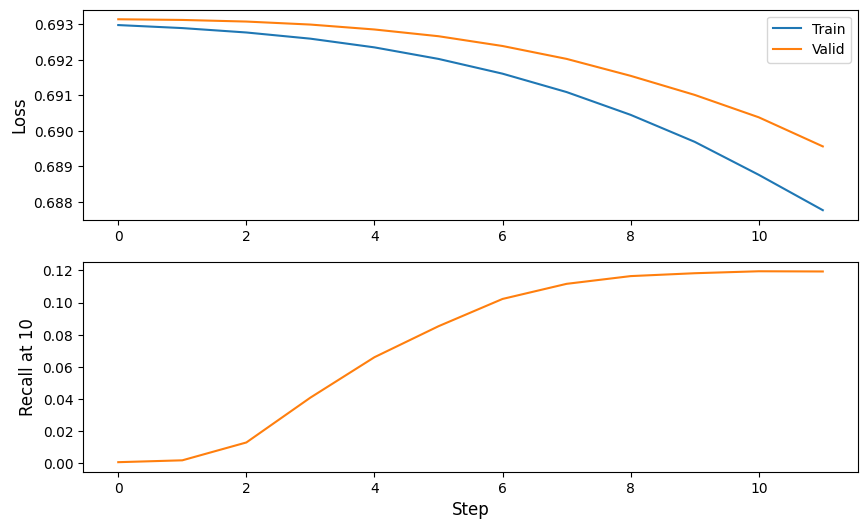

In [18]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3,1, figsize=(10,9))
ax[0].plot(metrics["loss_lgcn_train"], label="Train");
ax[0].plot(metrics["loss_lgcn_val"], label="Valid");
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].legend();
ax[1].plot(metrics["recall_k_val"], color="C1");
ax[1].set_ylabel("Recall at {}".format(hp["topk"]), fontsize=12);
ax[1].set_xlabel("Step", fontsize=12);
ax[2].plot(metrics["precision_k_val"], color="C1");
ax[2].set_ylabel("Precision at {}".format(hp["topk"]), fontsize=12);
ax[2].set_xlabel("Step", fontsize=12);

## Conclusion

* We built and trained a LightGCN model on the LastFM graph stored in a TigerGraph database.
* We learnt how to do recommendations with the trained LightGCN model.
* We learnt how to measure the quality of recommendations with Recall at K.